#### Import Required Modules

In [12]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score

from tensorflow.keras import layers, losses, Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from model import *

## Loading & Preprocessing Data
#### Feature Extraction - Load data from facebook dataset

In [2]:
# load data
X_features, labels, edges = load_data()

# check loaded properly
num_classes = len(np.unique(labels))
num_nodes = X_features.shape[0]
num_features = X_features.shape[1]
num_edges = len(edges)/2

print("num of classes: " + str(num_classes))
print("num of nodes: " + str(num_nodes))
print("num of features: " + str(num_features))
print("num of edges: "+ str(num_edges))

# adjacency matrix
A = get_adj_matrix(labels, edges)

num of classes: 4
num of nodes: 22470
num of features: 128
num of edges: 171002.0


#### Normalise Adjacency Matrix

In [3]:
# normalise
A = normalise_adj(A)

#### Split Training, Validation, and Testing

In [5]:
# Get indices for splitting set
train_idx, val_idx, test_idx = split_index(labels)

# Apply mask
train_mask = np.zeros((num_nodes,), dtype = bool)
val_mask = np.zeros((num_nodes,), dtype = bool)
test_mask = np.zeros((num_nodes,), dtype = bool)

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

<ipython-input-4-d953b9bd1601>:19: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_set = random.sample(remainder, k = size)


In [ ]:
# One-hot encoding
def encode(labels):
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels) # returns encoded labels
    encoded_labels = to_categorical(labels)
    return encoded_labels, encoder.classes_, encoder

encoded_labels, classes, encoder = encode(labels)

## Building & Training GCN

In [8]:
# Parameters
channels = 16 #num for first layer
dropout = 0.5 #rate
l_rate = 1e-2 #learning rate
l2_reg = 2.5e-4 # regularisation rate
epochs = 200 #number of epochs

In [9]:
# Create and Compile
model = GCN_Model(num_features, num_classes, channels, 
                  dropout, l2(l2_reg), num_nodes)

model.compile(optimizer = Adam(learning_rate = l_rate), 
              loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gcn__layer (GCN_Layer)          (None, 16)           2048        dropout[0][0]                    
                                                                 input_2[0][0]                

In [10]:
# Train
validation_data = ([X_features, A], encoded_labels, val_mask)
    
history = model.fit([X_features, A], 
              encoded_labels,
             sample_weight = train_mask,
             epochs = epochs,
             batch_size = num_nodes,
             validation_data = validation_data,
              shuffle = False)
    

Epoch 1/200
1/1 [==============================] - 18s 18s/step - loss: 0.3036 - acc: 0.2383 - val_loss: 0.2547 - val_acc: 0.3399
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.2682 - acc: 0.3380 - val_loss: 0.2293 - val_acc: 0.5217
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 0.2449 - acc: 0.4731 - val_loss: 0.2079 - val_acc: 0.6548
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.2230 - acc: 0.5942 - val_loss: 0.1896 - val_acc: 0.7223
Epoch 5/200
1/1 [==============================] - 2s 2s/step - loss: 0.2039 - acc: 0.6605 - val_loss: 0.1737 - val_acc: 0.7506
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.1874 - acc: 0.6974 - val_loss: 0.1600 - val_acc: 0.7650
Epoch 7/200
1/1 [==============================] - 2s 2s/step - loss: 0.1722 - acc: 0.7165 - val_loss: 0.1482 - val_acc: 0.7780
Epoch 8/200
1/1 [==============================] - 2s 2s/step - loss: 0.1603 - acc: 0.7305 - val_loss:

1/1 [==============================] - 2s 2s/step - loss: 0.0678 - acc: 0.8713 - val_loss: 0.0590 - val_acc: 0.9061
Epoch 65/200
1/1 [==============================] - 2s 2s/step - loss: 0.0680 - acc: 0.8687 - val_loss: 0.0589 - val_acc: 0.9067
Epoch 66/200
1/1 [==============================] - 2s 2s/step - loss: 0.0682 - acc: 0.8712 - val_loss: 0.0588 - val_acc: 0.9066
Epoch 67/200
1/1 [==============================] - 2s 2s/step - loss: 0.0677 - acc: 0.8721 - val_loss: 0.0587 - val_acc: 0.9067
Epoch 68/200
1/1 [==============================] - 2s 2s/step - loss: 0.0670 - acc: 0.8648 - val_loss: 0.0586 - val_acc: 0.9069
Epoch 69/200
1/1 [==============================] - 2s 2s/step - loss: 0.0720 - acc: 0.8664 - val_loss: 0.0585 - val_acc: 0.9073
Epoch 70/200
1/1 [==============================] - 2s 2s/step - loss: 0.0708 - acc: 0.8696 - val_loss: 0.0584 - val_acc: 0.9078
Epoch 71/200
1/1 [==============================] - 2s 2s/step - loss: 0.0682 - acc: 0.8702 - val_loss: 0.0583

1/1 [==============================] - 2s 2s/step - loss: 0.0633 - acc: 0.8780 - val_loss: 0.0559 - val_acc: 0.9117
Epoch 128/200
1/1 [==============================] - 2s 2s/step - loss: 0.0654 - acc: 0.8737 - val_loss: 0.0559 - val_acc: 0.9113
Epoch 129/200
1/1 [==============================] - 2s 2s/step - loss: 0.0640 - acc: 0.8722 - val_loss: 0.0559 - val_acc: 0.9118
Epoch 130/200
1/1 [==============================] - 2s 2s/step - loss: 0.0655 - acc: 0.8780 - val_loss: 0.0559 - val_acc: 0.9119
Epoch 131/200
1/1 [==============================] - 2s 2s/step - loss: 0.0654 - acc: 0.8726 - val_loss: 0.0559 - val_acc: 0.9125
Epoch 132/200
1/1 [==============================] - 2s 2s/step - loss: 0.0682 - acc: 0.8733 - val_loss: 0.0559 - val_acc: 0.9127
Epoch 133/200
1/1 [==============================] - 2s 2s/step - loss: 0.0649 - acc: 0.8709 - val_loss: 0.0559 - val_acc: 0.9124
Epoch 134/200
1/1 [==============================] - 2s 2s/step - loss: 0.0629 - acc: 0.8749 - val_loss:

1/1 [==============================] - 2s 2s/step - loss: 0.0634 - acc: 0.8761 - val_loss: 0.0541 - val_acc: 0.9150
Epoch 191/200
1/1 [==============================] - 2s 2s/step - loss: 0.0601 - acc: 0.8774 - val_loss: 0.0541 - val_acc: 0.9149
Epoch 192/200
1/1 [==============================] - 2s 2s/step - loss: 0.0633 - acc: 0.8813 - val_loss: 0.0541 - val_acc: 0.9145
Epoch 193/200
1/1 [==============================] - 1s 1s/step - loss: 0.0627 - acc: 0.8786 - val_loss: 0.0540 - val_acc: 0.9140
Epoch 194/200
1/1 [==============================] - 1s 1s/step - loss: 0.0630 - acc: 0.8752 - val_loss: 0.0539 - val_acc: 0.9136
Epoch 195/200
1/1 [==============================] - 2s 2s/step - loss: 0.0624 - acc: 0.8773 - val_loss: 0.0538 - val_acc: 0.9134
Epoch 196/200
1/1 [==============================] - 2s 2s/step - loss: 0.0619 - acc: 0.8780 - val_loss: 0.0538 - val_acc: 0.9137
Epoch 197/200
1/1 [==============================] - 2s 2s/step - loss: 0.0599 - acc: 0.8749 - val_loss:

## Results

Plot Accuracy and Loss Comparison

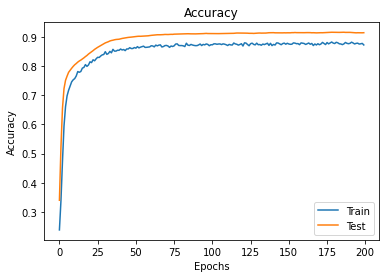

In [22]:
plt.plot(history.history.get('acc'))
plt.plot(history.history.get('val_acc'))

plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])

plt.savefig("model accuracy.jpeg")
plt.show()

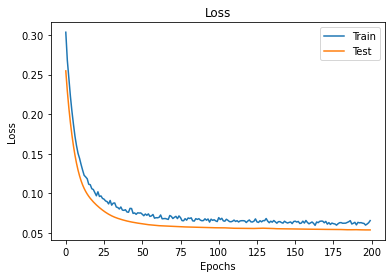

In [23]:
plt.plot(history.history.get('loss'))
plt.plot(history.history.get('val_loss'))

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])

plt.savefig("model loss.jpeg")
plt.show()

In [31]:
#X_test = X_features[test_mask]
#A_test = A[test_mask, :][:,test_mask]
y_test = encoded_labels[test_mask]

# Evaluation
y_predictions = model.predict([X_features, A], batch_size = num_nodes)

report = classification_report(np.argmax(y_test, axis=1), np.argmax(y_predictions[test_mask],axis=1), target_names = classes)
#f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_predictions[test_mask]))


TypeError: object of type 'numpy.int64' has no len()

## TSNE Plot

Each point is a node representing the facebook page. The colours represent the four possible categories.

In [32]:
## TEST SCRIPT ##
output = y_predictions

tsne = TSNE(n_components = 2).fit_transform(output)
plt.figure(figsize = (10,10))

colour_map = np.argmax(encoded_labels, axis = 1)
for class_ in range(num_classes):
    indices = np.where(colour_map == class_)
    lble = encoder.inverse_transform(class_)
    plt.scatter(tsne[indices[0], 0], tsne[indices[0],1], label = lble)
    
plt.title('tSNE Plot')
plt.legend()

plt.savefig("tsne_plot.jpeg")
plt.show()

NameError: name 'encoder' is not defined

<Figure size 720x720 with 0 Axes>